# Import Required Libraries

In [29]:
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

# nltk.download('stopwords')
# nltk.download('punkt_tab')
# nltk.download('wordnet')

stopwords = set(nltk.corpus.stopwords.words('english'))

In [2]:
# Dataset source: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/
# for the record, I defined the labels and combined the data before proceeding.
# Fake = 0, Real = 1
df = pd.read_csv('Dataset/dataset.csv')

In [3]:
df.head()

,title,text,subject,date,label
0,Big security risks in Trump feud with spy agen...,WASHINGTON (Reuters) - An unprecedented pre-pr...,politicsNews,"January 13, 2017",1
1,LEAKED EMAIL: Hillary’s Team Caught Bashing “B...,"As a Catholic, I m not sure what offends me mo...",left-news,"Oct 11, 2016",0
2,COMMUNIST George Soros Says Trump Will Win Pop...,George Soros: Here I have to confess to a lit...,left-news,"Sep 26, 2016",0
3,PRO-GUN University President Calls Hillary Cli...,"Liberty University President Jerry Falwell, Jr...",politics,"Dec 8, 2015",0
4,Paul Ryan Thought Nobody Would Notice His Tru...,House Speaker Paul Ryan is nothing but a spine...,News,"June 2, 2016",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


# Data Preprocessing

In [5]:
df.drop(columns=['subject', 'date'], inplace=True)

In [6]:
def preprocess_text(text: str):
    # 1. Convert text to lowercase
    def to_lower(text: str):
        return text.lower()

    # 2. Remove punctuation and numbers
    def remove_punctuation_numbers(text: str):
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\b(\d+)(st|nd|rd|th)\b', '', text)  # Remove Ordered Numbering
        return text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # 3. Tokenize text into words
    def tokenize(text: str):
        return word_tokenize(text)

    # 4. Remove stopwords (common words with little meaning)
    def remove_stopwords(tokens):
        return [word for word in tokens if word not in stopwords]

    # 5. Apply lemmatization (or stemming)
    lemmatizer = WordNetLemmatizer()
    def apply_lemmatization(tokens):
        return [lemmatizer.lemmatize(word) for word in tokens]

    text = to_lower(text)
    text = remove_punctuation_numbers(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = apply_lemmatization(tokens)
    return " ".join(tokens)

In [7]:
df['title'] = df['title'].apply(preprocess_text)
df['text'] = df['text'].apply(preprocess_text)

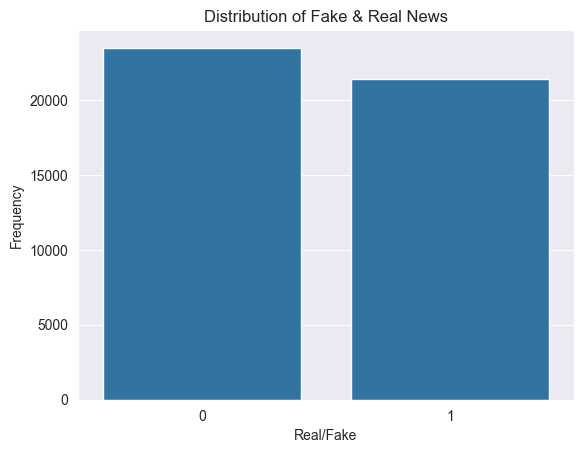

In [8]:
sns.countplot(df, x='label')
plt.title('Distribution of Fake & Real News')
plt.xlabel('Real/Fake')
plt.ylabel('Frequency')
plt.show()

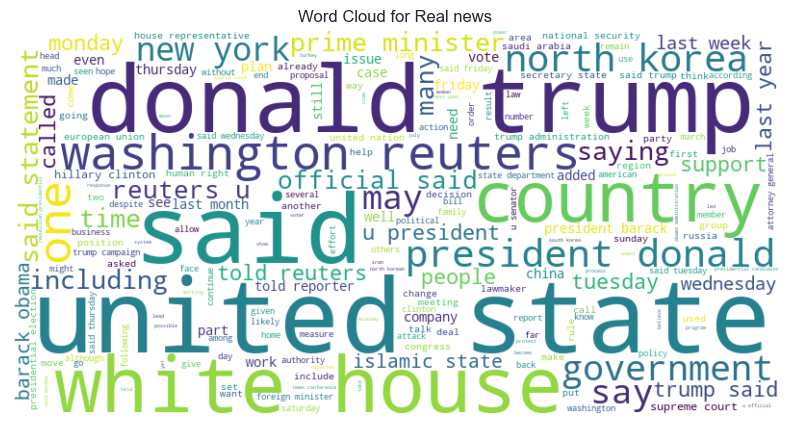

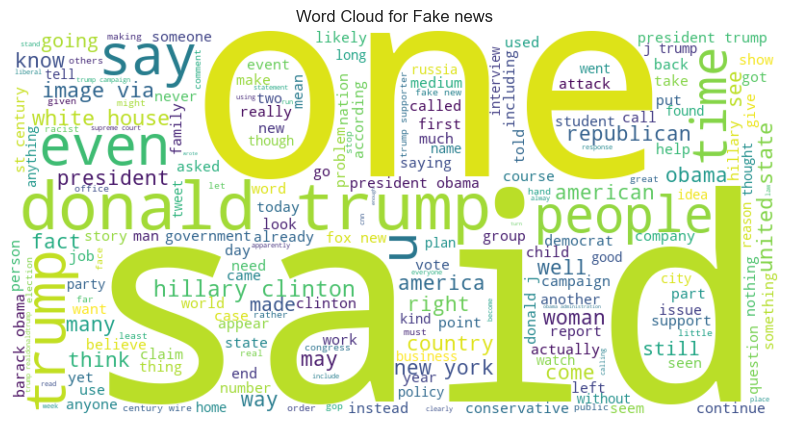

In [9]:
# Bonus: visualize most common words in fake and real dataset for text
for label in df['label'].unique():
    text = ' '.join(df[df['label'] == label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for { {1:'Real', 0:'Fake'}[label] } news")
    plt.show()


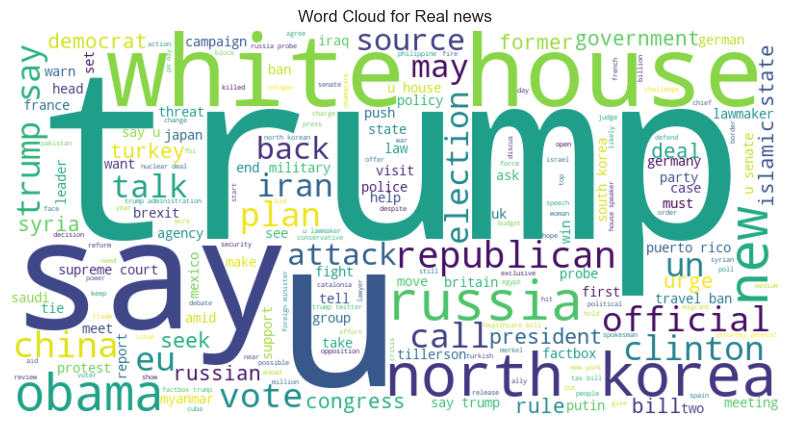

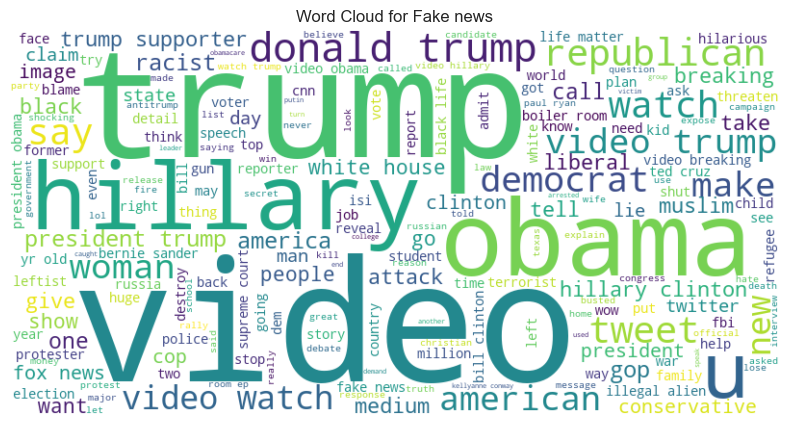

In [10]:
# Bonus: visualize most common words in fake and real dataset for titles
for label in df['label'].unique():
    text = ' '.join(df[df['label'] == label]['title'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for { {1:'Real', 0:'Fake'}[label] } news")
    plt.show()

# Feature Extraction

In [11]:
tfidf_text = TfidfVectorizer(ngram_range=(1, 4), max_features=10000)
tfidf_title = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

x1 = tfidf_text.fit_transform(df['text'])
x2 = tfidf_title.fit_transform(df['title'])
x = hstack([x1, x2])
y = df['label'].values

In [12]:
print(x.shape)
print(y.shape)

(44898, 15000)
(44898,)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [33]:
logreg = LogisticRegression(max_iter=10000, random_state=42)
svc = SVC(C=100, kernel='linear', random_state=42)

In [34]:
logreg.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [35]:
svc.fit(x_train, y_train)

,C,100
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [36]:
predicts = {
    'Logistic Regression - Train': logreg.predict(x_train),
    'Logistic Regression - Test': logreg.predict(x_test),
    'Support Vector Machine - Train': svc.predict(x_train),
    'Support Vector Machine - Test': svc.predict(x_test),
}

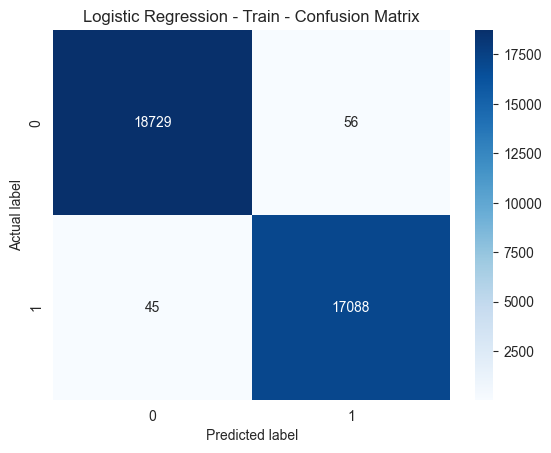

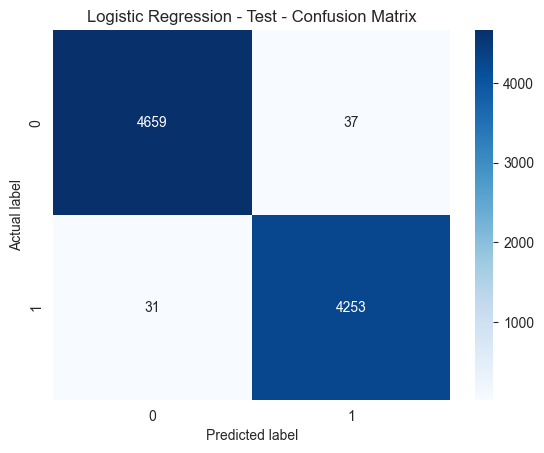

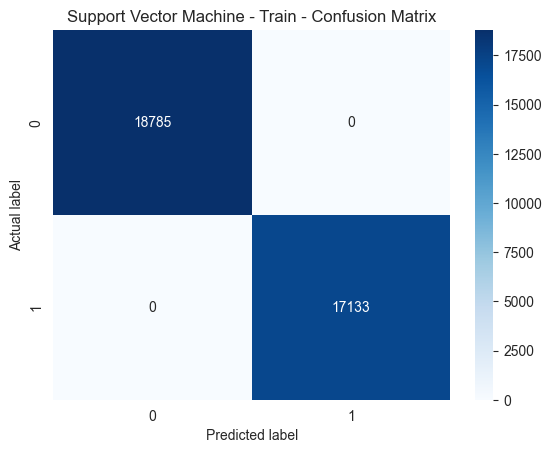

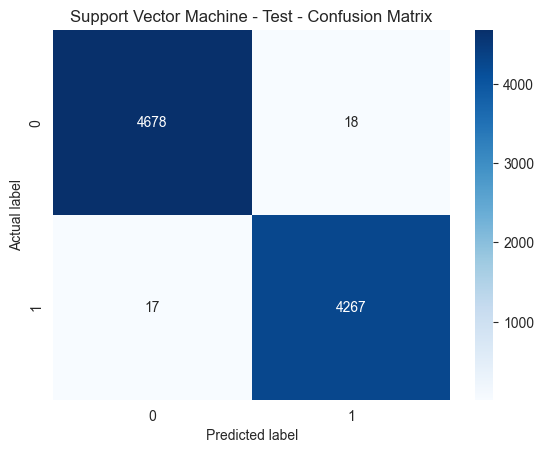

In [37]:
for name, y_pred in predicts.items():
    sns.heatmap(confusion_matrix(y_test if name.endswith("Test") else y_train, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.show()


In [38]:
for name, y_pred in predicts.items():
    print(f'Classification Report for {name}:\n{classification_report(y_test if name.endswith("Test") else y_train, y_pred)}\n')

Classification Report for Logistic Regression - Train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18785
           1       1.00      1.00      1.00     17133

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918


Classification Report for Logistic Regression - Test:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Classification Report for Support Vector Machine - Train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18785
           1       1.00      1.00      1.00     17133

    accuracy 

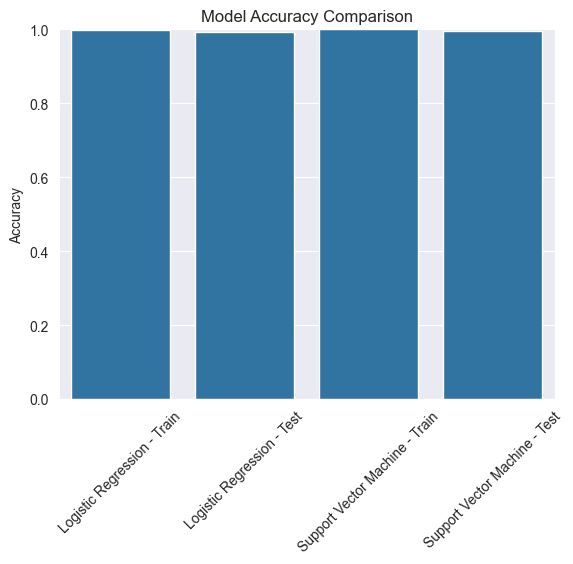

In [39]:
acc_scores = {}
f1_scores = {}

for name, y_pred in predicts.items():
    acc_scores[name] = accuracy_score(y_test if name.endswith("Test") else y_train, y_pred)
    f1_scores[name] = f1_score(y_test if name.endswith("Test") else y_train, y_pred, average='weighted')

plt.figure()
sns.barplot(x=list(acc_scores.keys()), y=list(acc_scores.values()))
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

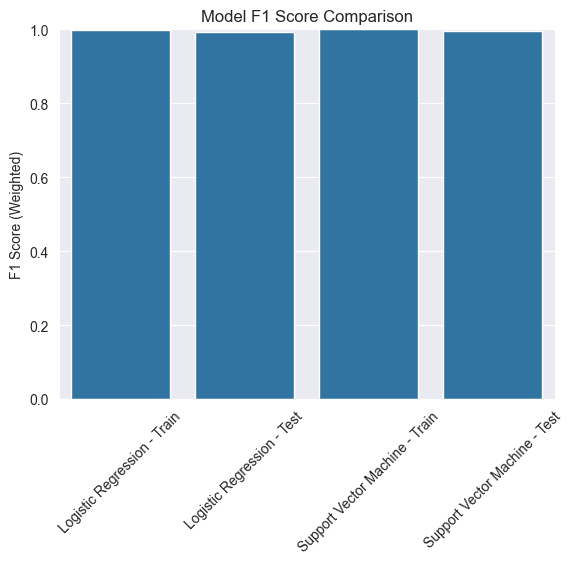

In [40]:
plt.figure()
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.title('Model F1 Score Comparison')
plt.ylabel('F1 Score (Weighted)')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

In [41]:
# Save models
from joblib import dump
dump(tfidf_text, 'Saved Models/TFIDF_for_text.joblib')
dump(tfidf_title, 'Saved Models/TFIDF_for_title.joblib')
dump(logreg,'Saved Models/Logistic Regression.joblib')
dump(svc, 'Saved Models/Support Vector Machine.joblib')

['Saved Models/Support Vector Machine.joblib']